In [4]:
!pip install SimpleITK
import SimpleITK as sitk
import numpy as np
import os
import math
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision.utils import make_grid
import torch.nn.functional as F
from datetime import datetime
from matplotlib import pyplot as plt


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.6/52.6 MB 18.8 MB/s eta 0:00:00


Mount Google Drive and load data

In [5]:
# Init pytorch device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [6]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [7]:
# DATA PATHS
datasetPath = 'MuscleTrainingSet'
outputPath = 'MuscleModel/'
if not os.path.exists(outputPath):
  os.makedirs(outputPath)
standardDatasetPath = datasetPath + '/StandardDataset/'
augmentedDatasetPath = datasetPath + '/LinearAugmentedDataset/'
# Image format extension:
extensionImages = 'mhd'
tagInPhase = '_I'
tagLabels = '_labels'

In [8]:
# GET DATA
# Check if the data is already in your folder. If it is not, download it
!ls
if os.path.exists(standardDatasetPath):
   !ls
else:
   !gdown --no-check-certificate --folder https://drive.google.com/drive/folders/1xjKT5iTfD6IrsFo8UTE7RdugtXzA_Mun?usp=sharing

drive  MuscleModel  sample_data
Retrieving folder list
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'drive.google.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
Retrieving folder 1cCDWA4KBgYHlS03IVvcYY5zoVfBsKXl3 StandardDataset
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'drive.google.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
Processing file 1Lkb6P-ty3iNAExUH__VlE_tsKTctbDFx images_training_set.mhd
Processing file 1ttrSq81Jg-3Dcl5N-a6gmBQO0ygv05vj images_training_set.raw
Processing file 1_P4BylbCweTl7yMEFrzhidFD-F1P4jcQ images_valid_set.mhd
Processing file 1dgw4tbZ7DG_DlUm_V

In [9]:
# READ AND PREPARE TRAINING SET
# Read data set which is already split into training set and validation set
sitkImagesTrainingSet = sitk.ReadImage(standardDatasetPath + 'images_training_set.mhd')
sitkLabelsTrainingSet = sitk.ReadImage(standardDatasetPath + 'labels_training_set.mhd')

sitkImagesValidSet = sitk.ReadImage(standardDatasetPath + 'images_valid_set.mhd')
sitkLabelsValidSet = sitk.ReadImage(standardDatasetPath + 'labels_valid_set.mhd')

# Convert simple itk images into numpy arrays:
imagesTrainingSet = sitk.GetArrayFromImage(sitkImagesTrainingSet)
labelsTrainingSet = sitk.GetArrayFromImage(sitkLabelsTrainingSet)
imagesValidSet = sitk.GetArrayFromImage(sitkImagesValidSet)
labelsValidSet = sitk.GetArrayFromImage(sitkLabelsValidSet)

# Cast to float (the model expects a float):
imagesTrainingSet = imagesTrainingSet.astype(np.float32)
labelsTrainingSet = labelsTrainingSet.astype(np.float32)
imagesValidSet = imagesValidSet.astype(np.float32)
labelsValidSet = labelsValidSet.astype(np.float32)

# Add a channel dimensions that is needed in pytorch.
imagesTrainingSet = np.expand_dims(imagesTrainingSet, axis=1)
labelsTrainingSet = np.expand_dims(labelsTrainingSet, axis=1)

imagesValidSet = np.expand_dims(imagesValidSet, axis=1)
labelsValidSet = np.expand_dims(labelsValidSet, axis=1)

# Check what is the training and valid size:
print(imagesTrainingSet.shape)
print(imagesValidSet.shape)
numImagesTrainingSet = imagesTrainingSet.shape[0]
numImagesValidSet = imagesValidSet.shape[0]

print('There are {0} 2D images in the training set and {1} in the valid set. The training set ratio is {2}'.format(
    numImagesTrainingSet, numImagesValidSet, numImagesTrainingSet/(numImagesTrainingSet+numImagesValidSet)
))

######################## TRAINING, VALIDATION AND TEST DATA SETS ###########################
trainingSet = dict([('input', imagesTrainingSet[:, :, :, :]), ('output', labelsTrainingSet[:, :, :, :])])
devSet = dict([('input', imagesValidSet[:, :, :, :]), ('output', labelsValidSet[:,:,:,:])])
print('Data set size. Training set: {0}. Dev set: {1}.'.format(trainingSet['input'].shape[0], devSet['input'].shape[0]))


(40, 1, 640, 800)
(18, 1, 640, 800)
There are 40 2D images in the training set and 18 in the valid set. The training set ratio is 0.6896551724137931
Data set size. Training set: 40. Dev set: 18.


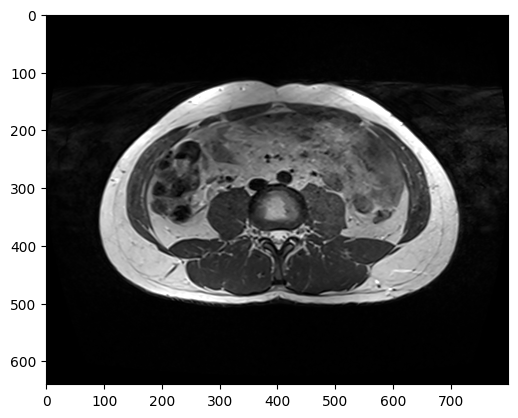

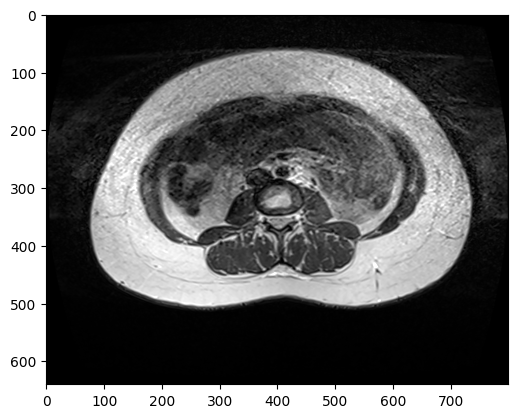

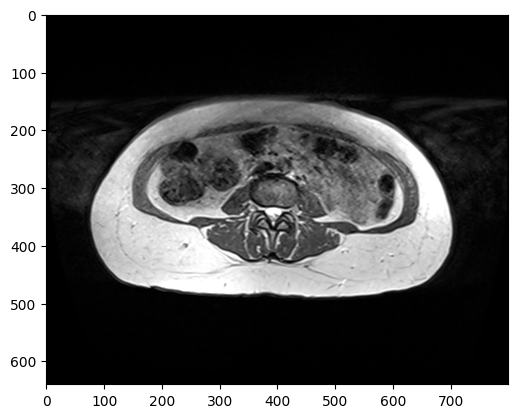

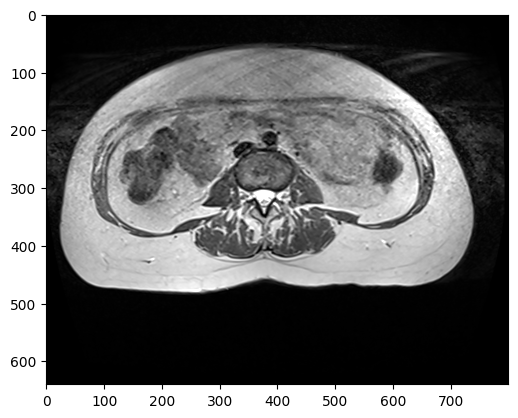

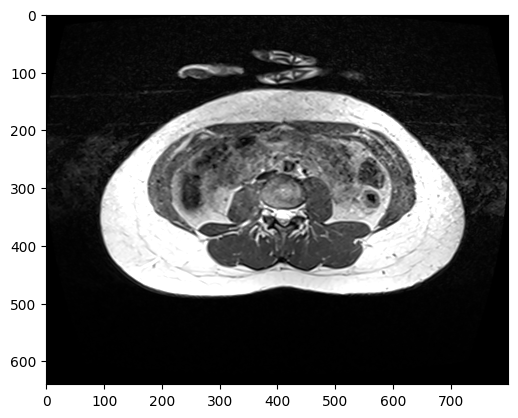

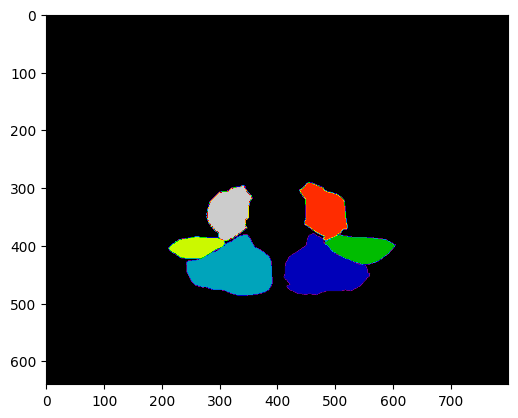

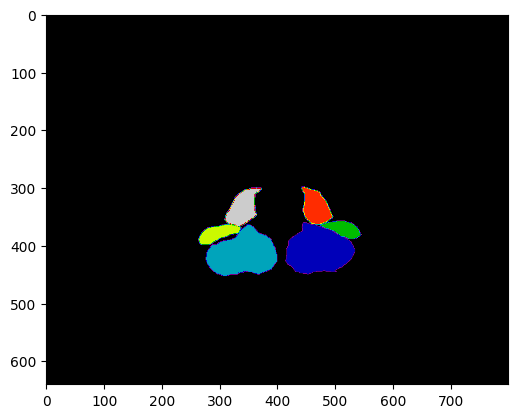

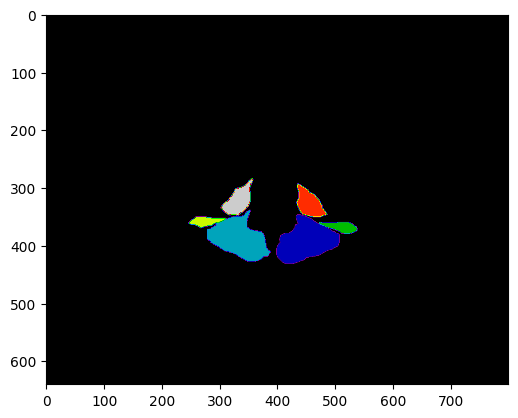

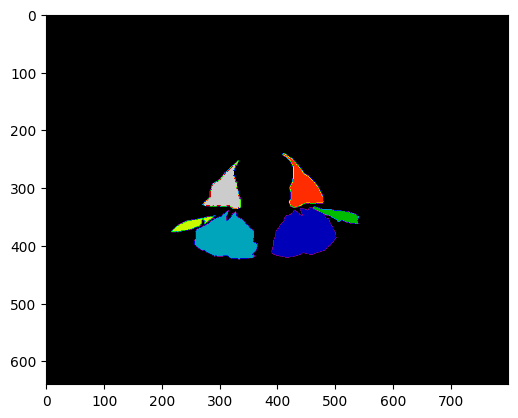

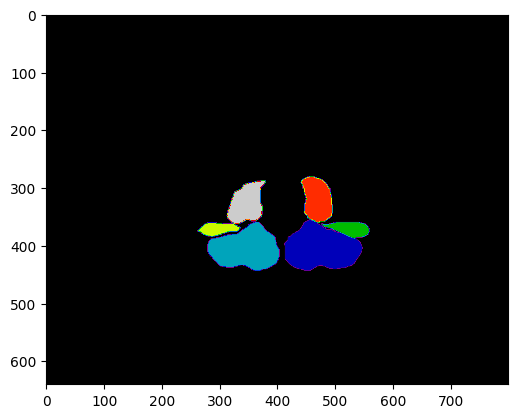

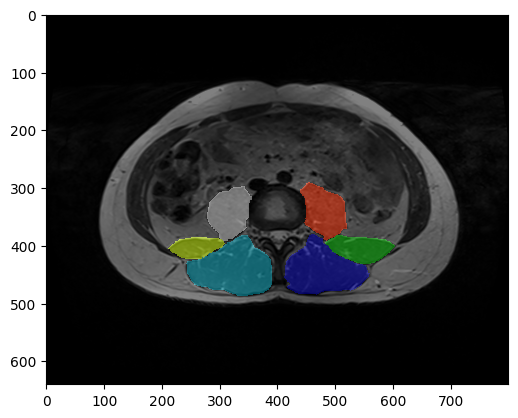

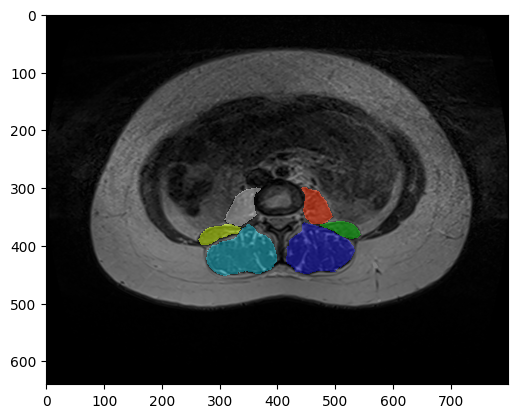

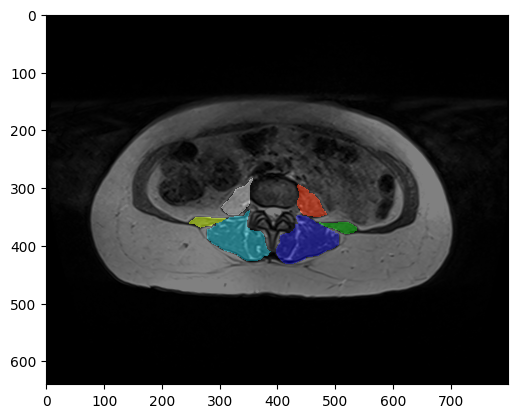

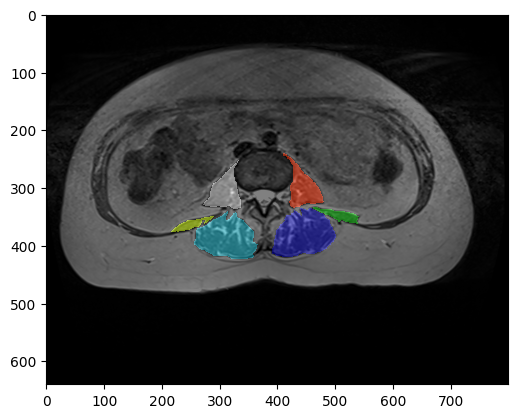

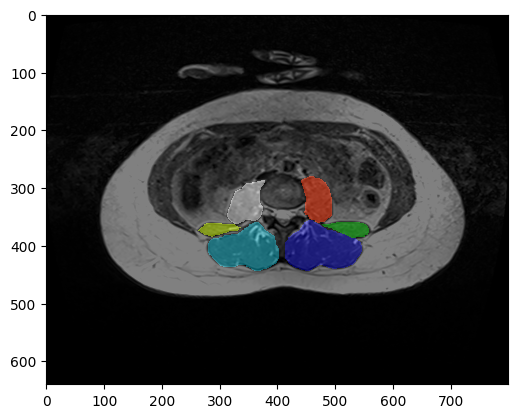

In [30]:
# Visualize Validation Set MRI Images
for i in range(0, 5):
    plt.imshow(imagesValidSet[i,0,:,:], cmap='gray', vmin=0, vmax=np.max(0.7*imagesValidSet[i,0,:,:]))
    plt.show()

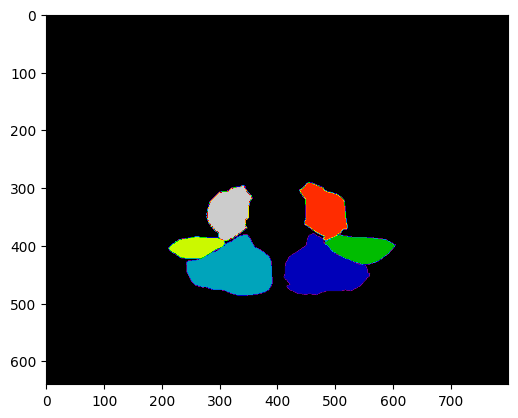

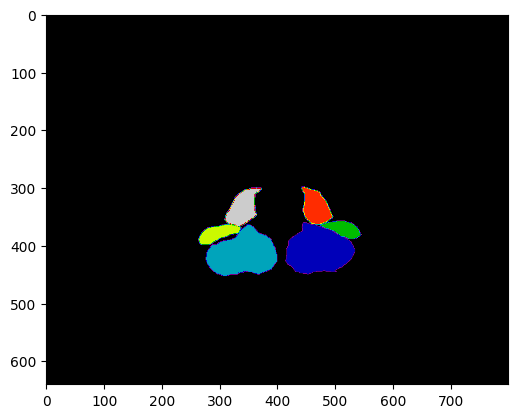

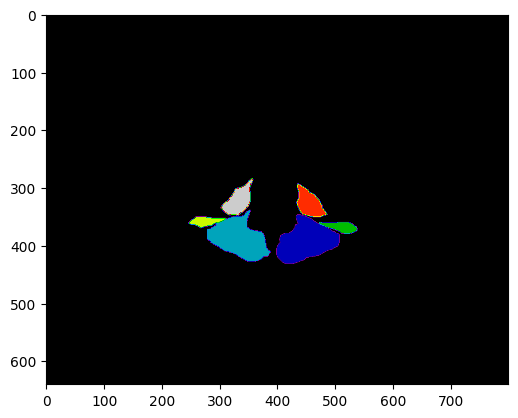

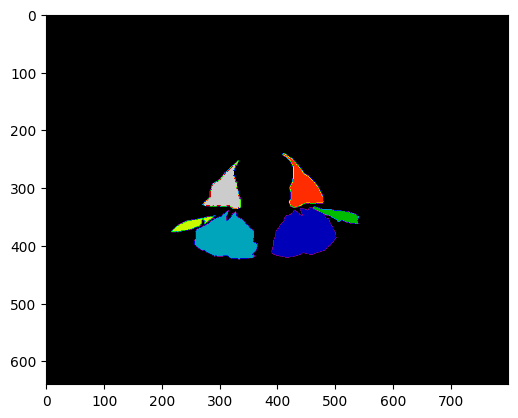

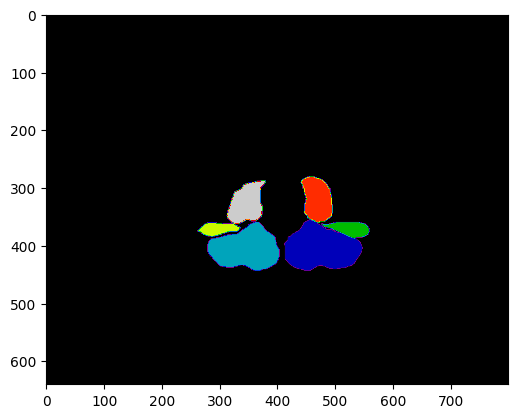

In [31]:
# Visualize Validation Set MRI Labels
for i in range(0, 5):
    plt.imshow(labelsValidSet[i,0,:,:], 'nipy_spectral')
    plt.show()

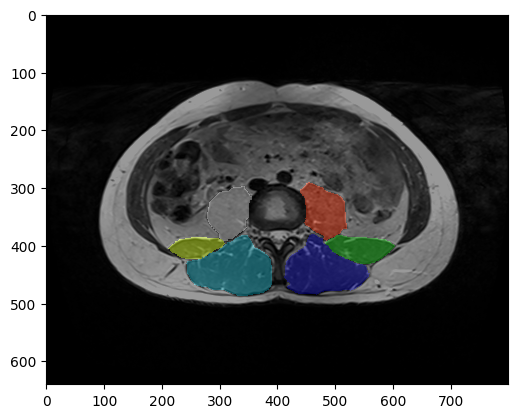

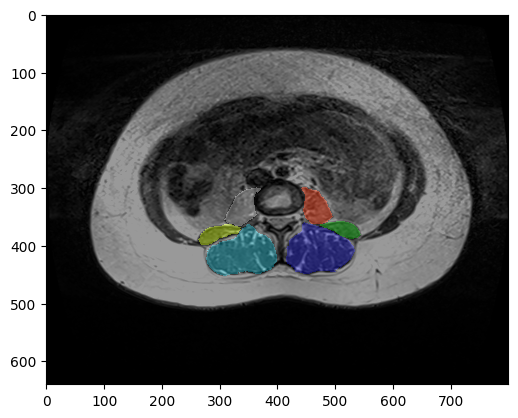

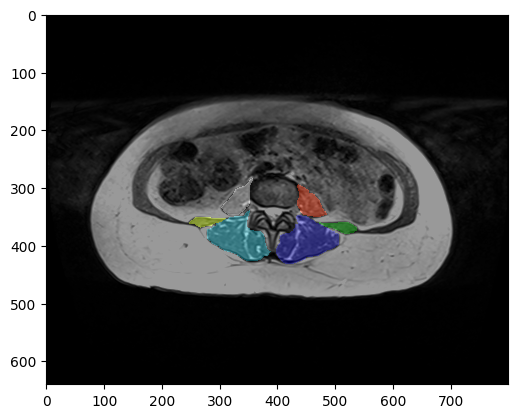

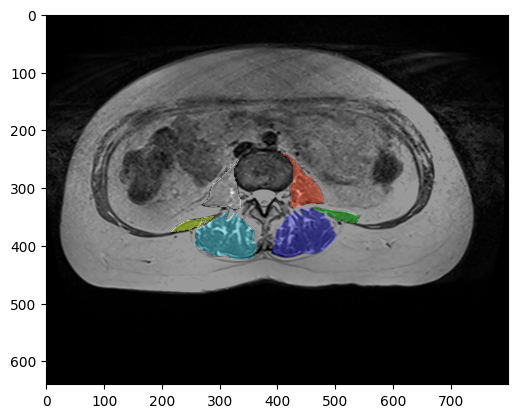

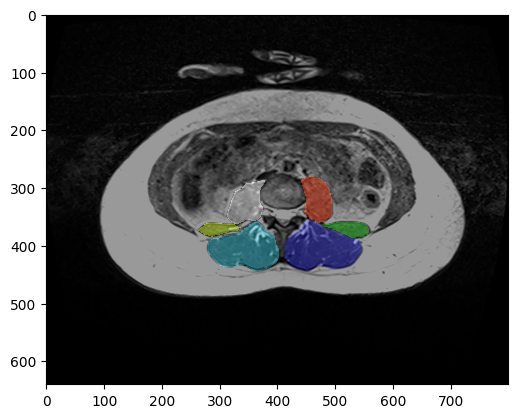

In [33]:

# Visualize Training Set Overlay Images
for i in range(0, 5):
    plt.imshow(imagesValidSet[i,0,:,:], cmap='gray', vmin=0, vmax=np.max(0.6*imagesValidSet[i,0,:,:]))
    plt.imshow(labelsValidSet[i,0,:,:], 'nipy_spectral', interpolation='none', alpha=0.4)
    plt.show()

In [25]:
# DEFINE A 2D UNET
class DoubleConv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            #nn.Dropout(),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True))
            #nn.Dropout())

    def forward(self, x):
        x = self.conv(x)
        return x


class InConv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(InConv, self).__init__()
        self.conv = DoubleConv(in_ch, out_ch)

    def forward(self, x):
        x = self.conv(x)
        return x


class Down(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(Down, self).__init__()
        self.mpconv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_ch, out_ch)
        )

    def forward(self, x):
        x = self.mpconv(x)
        return x


class Up(nn.Module):
    def __init__(self, in_ch, out_ch, bilinear = True):
        super(Up, self).__init__()

        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        else:
            self.up = nn.ConvTranspose2d(in_ch // 2, in_ch // 2, 2, stride=2)

        self.conv = DoubleConv(in_ch, out_ch)

    def forward(self, x1, x2):
        x1 = self.up(x1)

        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, (diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2))
        x = torch.cat([x2, x1], dim=1)
        x = self.conv(x)
        return x


class OutConv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_ch, out_ch, 1)

    def forward(self, x):
        x = self.conv(x)
        return x


class Unet(nn.Module):
    def __init__(self, in_channels, classes):
        super(Unet, self).__init__()
        self.n_channels = in_channels
        self.n_classes = classes

        self.inc = InConv(in_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        self.down4 = Down(512, 512)
        self.up1 = Up(1024, 256)
        self.up2 = Up(512, 128)
        self.up3 = Up(256, 64)
        self.up4 = Up(128, 32)
        self.outc = OutConv(32, classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        x = self.outc(x)
        return x

In [26]:
# Create a model and train it
# Create a UNET with one input and multiple output canal.
multilabelNum = 6 # Number of labels.
labelNames = ('Left Multifidus', 'Right Multifidus ', 'Left Quadratus ', 'Right Quadratus ', 'Left Psoas ','Right Psoas ')
xLabel = ['LM', 'RM', 'LQ', 'RQ', 'LP', 'RP']
# Loss function:
criterion = nn.BCEWithLogitsLoss()
# Maximum number of epochs during training:
max_epochs = 200
# Instanciate the unet with the number of output labels.
unet = Unet(1, multilabelNum)
optimizer = optim.Adam(unet.parameters(), lr=0.0001)

[0,     0] loss: 0.485
[0,     1] loss: 0.486
[0,     2] loss: 0.485
[0,     3] loss: 0.485
[0,     4] loss: 0.484
[0,     5] loss: 0.483
[0,     6] loss: 0.483
[0,     7] loss: 0.481
[0,     8] loss: 0.482
[0,     9] loss: 0.483
avg_tloss: 0.483582
avg_vloss: 0.487171
[1,     0] loss: 0.480
[1,     1] loss: 0.480
[1,     2] loss: 0.479
[1,     3] loss: 0.479
[1,     4] loss: 0.479
[1,     5] loss: 0.478
[1,     6] loss: 0.477
[1,     7] loss: 0.476
[1,     8] loss: 0.476
[1,     9] loss: 0.477
avg_tloss: 0.478258
avg_vloss: 0.486178
[2,     0] loss: 0.475
[2,     1] loss: 0.475
[2,     2] loss: 0.474
[2,     3] loss: 0.474
[2,     4] loss: 0.473
[2,     5] loss: 0.473
[2,     6] loss: 0.472
[2,     7] loss: 0.471
[2,     8] loss: 0.471
[2,     9] loss: 0.471
avg_tloss: 0.473044
avg_vloss: 0.480734
[3,     0] loss: 0.470
[3,     1] loss: 0.470
[3,     2] loss: 0.469
[3,     3] loss: 0.468
[3,     4] loss: 0.468
[3,     5] loss: 0.468
[3,     6] loss: 0.467
[3,     7] loss: 0.466
[3,   

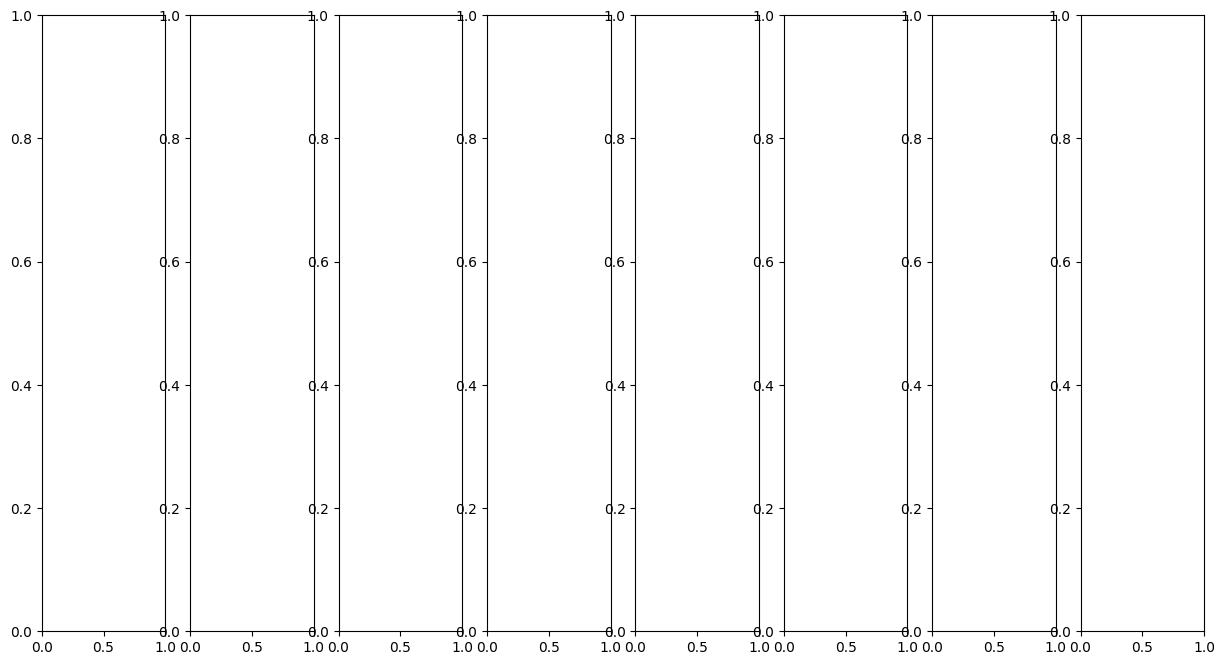

In [38]:
# TRAINING
# Number of  batches:
batchSize = 4
devBatchSize = 1
numBatches = np.ceil(trainingSet['input'].shape[0]/batchSize).astype(int)
devNumBatches = np.ceil(devSet['input'].shape[0]/devBatchSize).astype(int)
# Show results every printStep batches:
plotStep_epochs = 1 # math.inf to disable the plot.
numImagesPerRow = batchSize

timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')

if plotStep_epochs != math.inf:
    figGraphs, axs_graphs = plt.subplots(1, 8, figsize=(15, 8))
# Show dev set loss every showDevLossStep batches:
inputsDevSet = torch.from_numpy(devSet['input'])
gtDevSet = torch.from_numpy(devSet['output'])

best_diceScore = 0
best_loss = math.inf

skip_plot = 15       # early epoch loss values tend to hide later values
skip_model = 15            # avoids saving dataset images for the early epochs


iterationNumbers = []
iterationDevNumbers = []
epochNumbers = []

lossValuesTrainingSet = []
lossValuesDevSet = []

lossValuesTrainingSetAllEpoch = []
lossValuesDevSetAllEpoch = []

diceTrainingEpoch = [[] for n in range(multilabelNum)]
diceValidEpoch = [[] for n in range(multilabelNum)]

iter = 0
deviter = 0

unet.to(device)

for epoch in range(max_epochs):  # loop over the dataset multiple times
    epochNumbers.append(epoch)

    lossValuesTrainingSetEpoch = []
    lossValuesDevSetEpoch = []

    diceTraining = [[] for n in range(multilabelNum)]
    diceValid = [[] for n in range(multilabelNum)]

    #### TRAINING ####
    unet.train(True)
    for i in range(numBatches):
        # get the inputs
        inputs = torch.from_numpy(trainingSet['input'][i*batchSize:(i+1)*batchSize, :, :, :]).to(device)
        gt = torch.from_numpy(trainingSet['output'][i*batchSize:(i+1)*batchSize, :, :, :]).to(device)

        gt = F.one_hot(gt.to(torch.int64))
        gt = torch.squeeze(torch.transpose(gt, 1, 4), 4)
        gt = gt.float()
        gt = gt[:, 1:, :, :]
        # zero the parameter gradients
        optimizer.zero_grad()
        # Update the weights (backpropagation)
        outputs = unet(inputs)
        loss = criterion(outputs, gt)
        loss.backward()
        optimizer.step()

        # Save loss values:
        lossValuesTrainingSet.append(float(loss.item()))
        lossValuesTrainingSetEpoch.append(float(loss.item()))
        iterationNumbers.append(iter)
        #Print epoch iteration and loss value:
        print('[%d, %5d] loss: %.3f' % (epoch, i, loss.item()))

        # Update iteration number:
        iter = iter + 1
        label = gt.cpu().numpy()
        label = label.astype('int32')
        segmentation = torch.sigmoid(outputs.cpu().to(torch.float32))
        segmentation = segmentation.detach().numpy()
        indexImage = np.argmax(segmentation, axis=1)
        segmentation = (segmentation > 0.5) * 1

    avg_tloss = np.mean(lossValuesTrainingSetEpoch)
    lossValuesTrainingSetAllEpoch.append(avg_tloss)
    print('avg_tloss: %f' % avg_tloss)

    #### VALIDATION ####
    unet.train(False)
    torch.cuda.empty_cache()
    for i in range(devNumBatches):
        with torch.no_grad():
            inputs = torch.from_numpy(devSet['input'][i * devBatchSize:(i + 1) * devBatchSize, :, :, :]).to(device)
            gt = torch.from_numpy(devSet['output'][i * devBatchSize:(i + 1) * devBatchSize, :, :, :]).to(device)
            gt = F.one_hot(gt.to(torch.int64))
            gt = torch.squeeze(torch.transpose(gt, 1, 4), 4)
            gt = gt.float()
            gt = gt[:, 1:, :, :]

            outputs = unet(inputs)
            loss = criterion(outputs, gt)

            lossValuesDevSet.append(loss.item())
            lossValuesDevSetEpoch.append(loss.item())

            iterationDevNumbers.append(deviter)
            deviter = deviter + 1

        label = gt.cpu().numpy()
        label = label.astype('int32')
        segmentation = torch.sigmoid(outputs.cpu().to(torch.float32))
        segmentation = segmentation.detach().numpy()
        indexImage = np.argmax(segmentation, axis=1)
        #outImage[:, k, :, :] = image[:, k, :, :] * (indexImage == k)
        segmentation = (segmentation > 0.5) * 1

    avg_vloss = np.mean(lossValuesDevSetEpoch)
    lossValuesDevSetAllEpoch.append(avg_vloss)
    print('avg_vloss: %f' % avg_vloss)

    if (avg_vloss < best_loss) and (epoch >= skip_model):
        best_loss = avg_vloss
        print('[validation Epoch: %d] best_loss: %.3f' % (epoch, avg_vloss))
        modelPath = outputPath + 'unet_{}_{}_best_fit'.format(timestamp, epoch) + '.pt'
        torch.save(unet.state_dict(), modelPath)


print('Finished Training')
torch.save(unet.state_dict(), outputPath + 'unet.pt')
torch.save(unet, outputPath + 'unetFullModel.pt')

In [34]:
# Load the best model and segment the validation set
#TODO


IndexError: ignored

In [ ]:
# Visualizing output images:
#TODO

drive  MuscleModel  MuscleTrainingSet  sample_data
